# Models regression

Each model will be regressed with Scipy librairy which implements the least quare method of optimization. 

In [1]:
# L2 loss to evaluate my models 

def l2_loss(y_real, y_predicted):
    l2_err = np.sqrt((y_real-y_predicted)**2)
    return np.sum(l2_err)

## Linear regression

The model is the following:
* $ y = y_{0}+rx $
* $ y_{0} $ is the initial value of monitored variable 
* $ r $ is the growth-rate of this value

In [2]:
import numpy as np 
from scipy.stats import linregress
import matplotlib.pyplot as plt

def lin_fun_scalar(x, y0 = 0, r = 1): 
    return y0 + r*x

lin_fun = np.vectorize(lin_fun_scalar)

def linReg(x,y) :
    a, b, cor, p_value, std_err = linregress(x, y)
    plt.scatter(x,y)
    ypred=lin_fun(x, b,a ) 
    plt.plot(x,ypred )
    print('y0='+str(b))
    print('r='+ str(a))
    print('loss='+str(l2_loss(y, ypred)))
    return a, b, cor, std_err


A simple example :

y0=2.3533216552351597
r=2.8949045722673517
loss=7.53260903083041


(2.8949045722673517,
 2.3533216552351597,
 0.9941840612938062,
 0.11087024143534105)

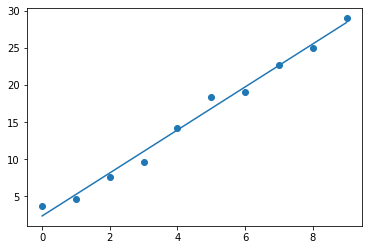

In [3]:

x = np.arange(0,10)
y= lin_fun(x, 2,3) +[np.random.normal(0, 0.8) for i in range(len(x))]
linReg(x,y)



## Exponential regression: 

The model is the following:
* $ y = y_{0}e^{rt} $
* $ y_{0} $ is the initial value of monitored variable 
* $ r $ is the growth-rate of this value

In [4]:
from math import exp

def exp_fun_scalar(x, y0 = 0, r = 1): 
    return y0*exp(r*x)

exp_fun = np.vectorize(exp_fun_scalar)

In [5]:
def expReg(x,y) :

    a, b, cor, p_value, std_err = linregress(x, np.log(y))
    plt.scatter(x,y)
    y0 = exp(b)
    r = a
    xmax = np.max(x)
    xmin = np.min(x)
    x_plot = np.linspace(xmin,xmax,200)
    plt.plot(x_plot, exp_fun(x_plot, y0,r ))
    return r, y0

(1.1386754501460232, 0.23036844410470356)

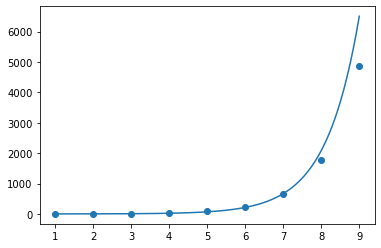

In [6]:
x = np.arange(1,10)
y= exp_fun(x, 0.6,1)+[np.random.normal(0, 2) for i in range(len(x))]
expReg(x,y)


## Logistic curve

The model is the following:
* $ y = \frac{K}{1+e^{-\frac{ln(81)}{\Delta t}(t-t_{m})}}$
* $ \Delta t $ is the time needed for y to increase from 10% to 90% of the max value of K (characteristic duration)
* $ t_{m} $ midpoint (50% K)
* $K$ is the saturation value

In [7]:
from math import log, exp
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData

def log_fun_scalar(x, K = 10, dt = 50, tm=25): 
    return K/(1+exp((-log(81)/dt)*(x-tm)))

log_fun = np.vectorize(log_fun_scalar)

def initialLogParams(x, y) :
    K = np.max(y)
    m= np.array([abs(0.5*K-y[i]) for i in range(len(y))]).argmin()
    m1 = np.array([abs(0.1*K-y[i]) for i in range(len(y))]).argmin()
    m9 = np.array([abs(0.9*K-y[i]) for i in range(len(y))]).argmin()
    tm = x[m]
    dt = x[m9]-x[m1]

    return K, dt, tm

def logReg (x, y, Dy = None) :
    K0, dt0, tm0 = initialLogParams(x,y)
    print(tm0,dt0,K0)
    print(tm0, dt0, K0)
    lower = 0
    upper = 0
    bounds = [0, 90000]
    popt, pcov = curve_fit(
        f = log_fun,       # model function
        xdata=x,   # x data
        ydata=y,   # y data
        p0=(K0, dt0, tm0),      # initial value of the parameters
        bounds = bounds,
        sigma=Dy
    )
    K, dt, tm = popt
    
    xmax = np.max(x)
    xmin = np.min(x)
    x_plot = np.linspace(xmin,xmax,200)
    plt.scatter(x,y)
    plt.plot(x_plot, log_fun(x_plot, K,dt,tm ))
    return K, dt, tm


20 40 8.680729177507763
20 40 8.680729177507763


(10.081522176171026, 49.93800309760583, 25.23925683470952)

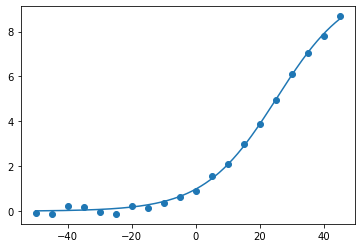

In [8]:
x = np.arange(-50,50, 5)
y= log_fun(x)+[np.random.normal(0, 0.1) for i in range(len(x))]
logReg(x,y)

## Normal regression

The model is the following:
* $ y =\frac{1}{\sqrt{2 \pi}\sigma}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^{2}}$
* $ \mu $ is the x value of the max
* $ \sigma $is the standard deviation of the global serie

In [9]:
from math import pi, sqrt
def norm_fun_scalar(x, mu = 20, sigma = 10): 
    return 1/(sqrt(2*pi)*sigma)*exp(-0.5*(((x-mu)/sigma))**2)

norm_fun = np.vectorize(norm_fun_scalar)

def initialNormParams(x, y) :
    mu = x[np.argmax(y)]
    max = np.max(y)
    sigma= 1/(max*sqrt(2*pi))
    
    return mu,sigma

(19.96696544180437, 9.912141868901431)

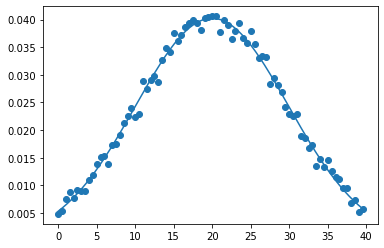

In [10]:
def NormReg (x, y, Dy = None) :
    mu0, sigma0 = initialNormParams(x,y)
    lower = 0
    upper = 8*mu0+1
    bounds = [lower, upper]
    popt, pcov = curve_fit(
        f = norm_fun,       # model function
        xdata=x,   # x data
        ydata=y,   # y data
        p0=(mu0, sigma0),      # initial value of the parameters
        bounds = bounds,
        sigma=Dy
    )
    mu, sigma = popt
    
    xmax = np.max(x)
    xmin = np.min(x)
    x_plot = np.linspace(xmin,xmax,200)
    plt.scatter(x,y)
    plt.plot(x_plot, norm_fun(x_plot, mu, sigma))
    return mu, sigma

x = np.arange(0,40, 0.5)
y= norm_fun(x)+[np.random.normal(0, 0.001) for i in range(len(x))]
NormReg(x,y)

## Complex S-curve

The model is the following:
$ E = f(g) = E_{i} + A \frac{e^{\alpha _{1}(g-G_{i})}-e^{\alpha _{3}(g-G_{i})}}{2cosh( \alpha_{2}(g-G_{i}))} $

In [11]:
def s_model(x, G_i, A, a1, a2, a3):
    """
    s_model(g) = e-E_i
    """
    return  A*(pd.np.exp(a1*(x-G_i)) - pd.np.exp(-a3*(x-G_i)))/(pd.np.cosh(a2*(x-G_i)))

In [12]:
import math as math
import sympy as sy
def remarking_points(G, E, deg = 6, step = 0.1) : 
    """
    This function returns the inflexion point, the zero_growth point and the take-off point of f where (f(g) = e) thanks to the data points
    degree: int, degree of the polynomial regression, default value 6 
    step: step used for the estimation of the inflexion point 
    """
    # regression of a polynomial function
    G = G[:, np.newaxis]
    E = E[:, np.newaxis]
    polynomial_features= PolynomialFeatures(degree=deg)
    G_poly = polynomial_features.fit_transform(G)
    model = LinearRegression()
    model.fit(G_poly, E)
    y_poly_pred = model.predict(G_poly) 

    # computing numerous points to improve our prediction
    max_gdp = np.amax(np.array(G))
    min_gdp = G.min()
    G_calc = np.linspace(min_gdp, max_gdp, 200)
    G_calc = G_calc[:, np.newaxis]
    G_calc_poly = polynomial_features.fit_transform(G_calc)

    E_poly_pred_calc = model.predict(G_calc_poly )
    E_poly_pred_calc = np.array([E_poly_pred_calc[i][0] for i in range(len(E_poly_pred_calc))])

    #inflexion point
    idx_infl = int(np.diff(E_poly_pred_calc[4:] ).argmax())
    G_i = G_calc[idx_infl][0]
    G_dist = np.array([abs(g-G_i) for g in G])
    id_i = G_dist.argmin()
    E_i = E[id_i][0]

    # zero-growth point 
    G_z = G[E.argmax()]
    E_z = E.max()

    # Take-off point 
    G_t = G[id_i//3]
    E_t = E[id_i//3]

    # slope before the take-off point kl
    kl = (E_t-E[0])/(G_t-G[0])[0]
    # slope between take-off point and the zero-growth point ki
    ki = (E_z-E_t)/(G_z-G_t)
    # slope after the zero-growth point kv
    n = len(G)-1
    kv = (E[n]-E_z)/(G[n]-G_z)[0]

    # parameters
    eth_1 = 0.5*(ki+kl+kv)*(G_z-G_i)
    eth_2 = 0.5*(kl+2*ki-kv)*(G_z-G_i)
    eth_3 = (kl+ki+kv)/(kl+2*ki-kv)
    
    A = find_A(1,10, eth_1, eth_2, eth_3)

    alpha_1 = (kl+ki+kv)/(2*A)
    alpha_2 = (kl+2*ki-kv)/(2*A)
    alpha_3 = (-kl+2*ki-kv)/(2*A)


    return {'inflexion' : (G_i,E_i), 'zero_growth':(G_z,E_z), 'take_off' : (G_t, E_t), 'kl': kl, 'ki':ki, 'kv':kv, 'A':A, 'alpha_1' : alpha_1, 'alpha_2':alpha_2, 'alpha_3': alpha_3}
def f(A, eth_1, eth_2, eth_3) :
    return math.tanh(eth_1/A)*math.tanh(eth_2/A)-eth_3

def find_A(A_min, A_max, eth_1, eth_2, eth_3, epsilon=10**-3) :
    """
    This function based on dichotomy allows me to estimate the value of A variable (cf article)
    """
    while A_max-A_min > epsilon :
        A = (A_min+A_max)/2
        if f(A, eth_1, eth_2, eth_3) ==0 :
            return A  
        elif f(A_min, eth_1, eth_2, eth_3)*f(A_max, eth_1, eth_2, eth_3)< 0:
            A_max =A
        else :
            A_min = A

    return (A_min+A_max)/2




In [13]:
def s_curve_fitting(f_model, xdata, ydata, Dy,  bounds = [0, 35000]):
    params = remarking_points(xdata, ydata, deg=6, step = 0.1)
    G_i, E_i= params['inflexion']
    A= abs(params['A'])
    a1 = abs(params['alpha_1'][0])
    a2 = abs(params['alpha_2'][0])
    a3 = abs(params['alpha_3'][0])
    p0 = ( G_i, A, a1, a2, a3)
    y = [ydata[i]-E_i for i in range (len(ydata))]


    popt, pcov = curve_fit(
        f = f_model,       # model function
        xdata=xdata,   # x data
        ydata=y,   # y data
        p0=p0,      # initial value of the parameters
        bounds = bounds,
        sigma=Dy
    )
    G, A, a1, a2, a3  = popt
    xmax = np.max(xdata)
    xmin = np.min(xdata)
    x_plot = np.linspace(xmin,xmax,200)
    plt.scatter(xdata, ydata)
    plt.plot(x_plot, f_model(x_plot,G, A, a1, a2, a3 )+E_i)

    return popt, E_i


## Attemps

In [14]:
import pandas as pd
gpec = pd.read_csv('../BDD/global-energy-substitution.csv')
tab = gpec.drop(['Entity', 'Code', 'Year'], axis = 1, inplace = False).to_numpy()
total = np.array([tab[i].sum() for i in range (len(tab))])
gpec['Total (TWh)'] = total
gdp= pd.read_csv('../BDD/world-gdp-over-the-last-two-millennia.csv')
population = pd.read_csv('../BDD/world-population-1750-2015-and-un-projection-until-2100.csv')
population.describe()

,Year,World Population over 12000 years (various sources (2019)),Medium Projection (UN Population Division (2019 revision))
count,23313.000000,4.710000e+02,2.284200e+04
mean,2035.832926,3.220889e+09,3.251268e+08
std,405.789044,3.540940e+09,1.185581e+09
min,-10000.000000,1.000000e+06,1.000000e+03
25%,2039.000000,3.600000e+08,8.480000e+05
50%,2059.000000,1.778265e+09,1.019950e+07
75%,2080.000000,5.295000e+09,6.680175e+07
max,2100.000000,1.087490e+10,1.087490e+10


In [15]:
new = pd.merge(gdp, gpec, on = ['Year'])[['Year', 'World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))', 'Total (TWh)']]
population.head()
len(population['World Population over 12000 years (various sources (2019))'].dropna())+len(population['Medium Projection (UN Population Division (2019 revision))'].dropna())

23313

In [16]:
tab1 = population[['Year', 'World Population over 12000 years (various sources (2019))']].dropna()
tab1 = tab1.rename(columns = {'World Population over 12000 years (various sources (2019))': 'Population'})
tab2 = population[['Year', 'Medium Projection (UN Population Division (2019 revision))']].dropna()
tab2 = tab2.rename(columns = {'Medium Projection (UN Population Division (2019 revision))': 'Population'})
pop = pd.concat([tab1, tab2])
pd.to_numeric(pop['Year'])
pd.to_numeric(new['Year'])
final=pd.merge(new, pop, on = ['Year'])

In [17]:
time = final['Year']
p = final['Population']
gdp = final['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']
energy = final['Total (TWh)']

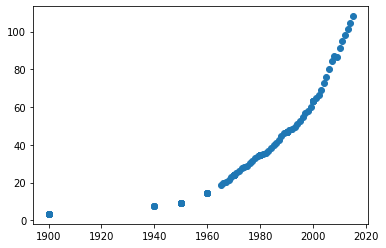

In [18]:
g = gdp/10**12
plt.scatter(time, g)

Loss = 3785.735233266396


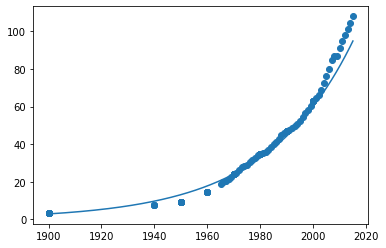

In [19]:
r, y0 = expReg(time, g)
ypred = exp_fun(time, r, y0)
print('Loss = '+ str(l2_loss(g, ypred)))

1996 62 108.12
1996 62 108.12
loss=161.58669500298882


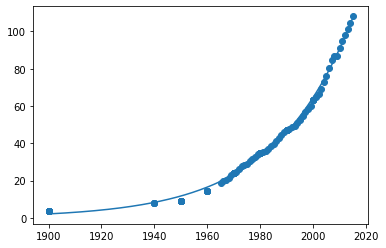

In [20]:
logReg(time, g)
ypred= log_fun(time,7268.071354164946, 128.07312003413853, 2137.3588892938615 )
print('loss='+str(l2_loss(ypred, g)))

[]

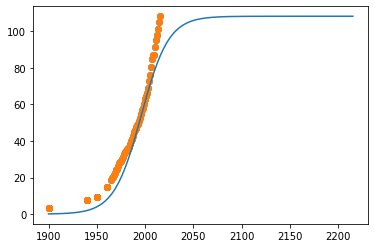

In [21]:
plt.scatter(time,g)
xmax = np.max(time)
xmin = np.min(time)
x_plot = np.linspace(xmin,xmax+200,200)
plt.scatter(time,g)
plt.plot(x_plot, log_fun(x_plot, 108.12,62,1996 ))
plt.plot()

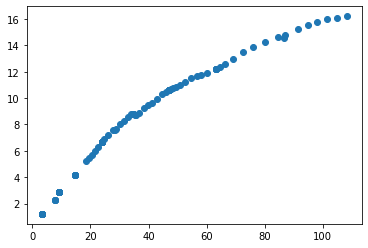

In [22]:
e = energy / 10**4

plt.scatter(g, e)


1976 109 16.2024
1976 109 16.2024


(23.902079966278073, 115.00497987088647, 1996.549173413592)

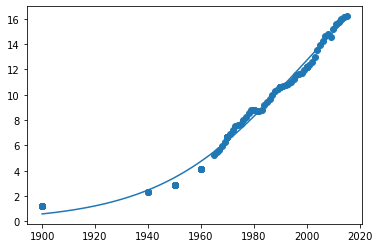

In [23]:
logReg(time,e)

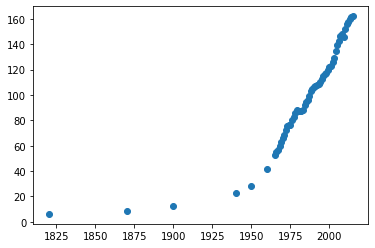

In [24]:
energy = new['Total (TWh)']/10**3
time = new['Year']
plt.scatter(time, energy)

1976 109 162.024
1976 109 162.024


(278.3463569427426, 130.7768405338225, 2005.2935984283517)

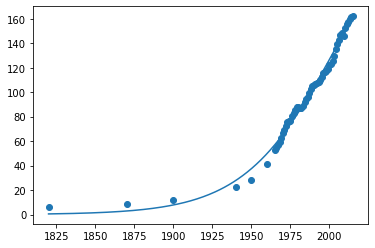

In [25]:
logReg(time, energy)

In [26]:
from regressions import sReg
G_i, E_i, A, alpha_1, alpha_2, alpha_3 = sReg(time, energy)

(1987, 99.479, 9.999725341796875, 0.17480874749911599, 0.1883782691333279, 0.15240768657717627)


(1987, 99.479, 9.999725341796875, 0.17480874749911599, 0.1883782691333279, 0.15240768657717627)


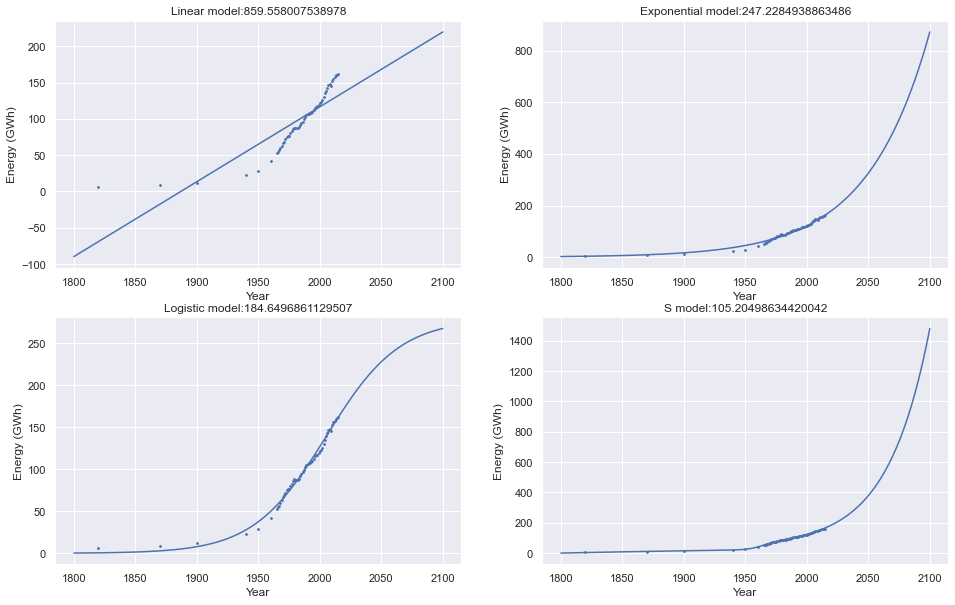

In [27]:
from visualization import test_models
test_models(time, energy, x_title = 'Year', y_title='Energy (GWh)', xmin = 1800, xmax = 2100)

(0.0428128962218747, 99.479, 9.999725341796875, 204.2073852344675, 235.31976994613598, -26.60321075426892)


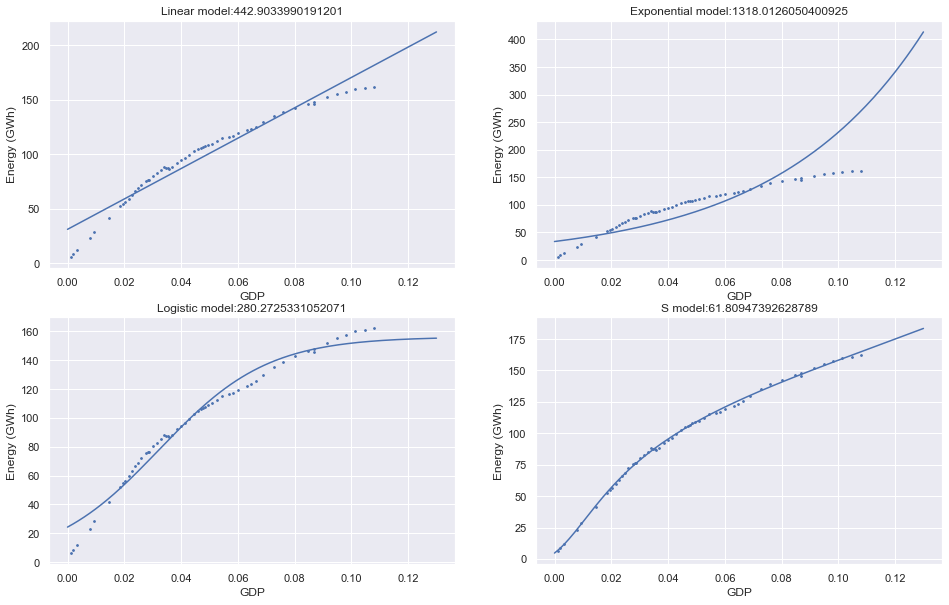

In [28]:
GDP = new['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']/10**15
test_models(GDP, energy, xmin = 0, xmax= 0.13, x_title="GDP", y_title='Energy (GWh)')

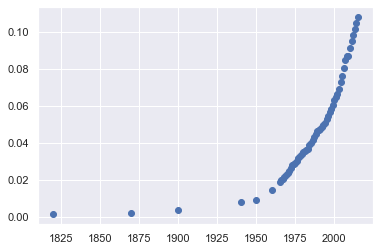

In [29]:
plt.scatter(time, GDP)

(1987, 0.428128962218747, 9.999725341796875, 0.002689936002448992, 0.00021106370379923094, 7.372726066372016e-05)


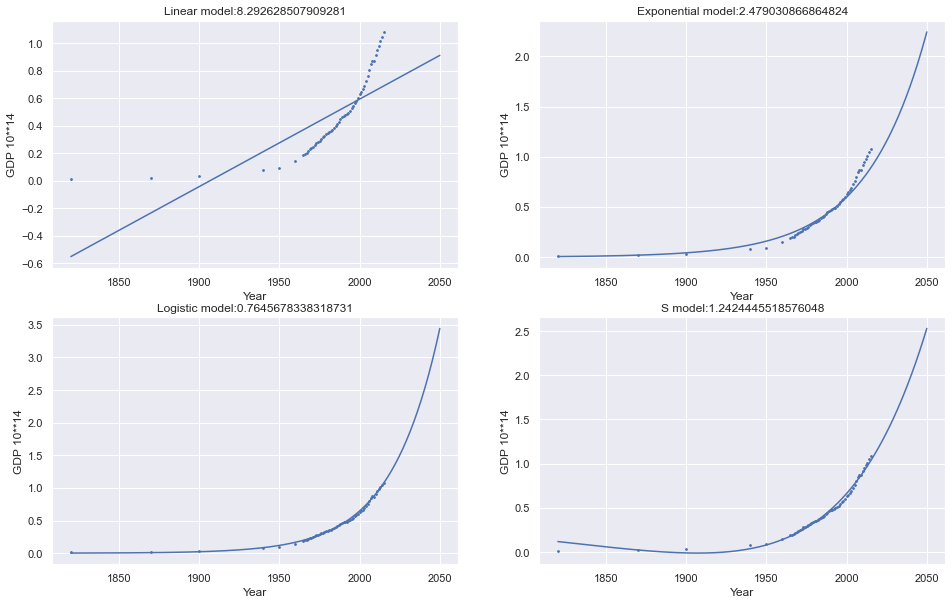

In [30]:
GDP = new['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']/10**14
test_models(time, GDP, logbounds = [0,2150], xmin= 1820, xmax=2050, x_title='Year', y_title='GDP 10**14')

In [31]:
import regressions as reg
reg.logReg(time, GDP, bounds= [0, 2150])

(106.38119331618276, 129.3548199904371, 2149.999999997295)

In [32]:
reg.sReg(time, GDP)

(1987, 0.428128962218747, 9.999725341796875, 0.002689936002448992, 0.00021106370379923094, 7.372726066372016e-05)


(1986.9996170782117,
 0.4307326657552252,
 9.999704131923053,
 0.014066166635392542,
 1.2281489913113439e-05,
 -0.011047925375544339)

In [33]:
reg.sReg(time, energy)

(1987, 99.479, 9.999725341796875, 0.17480874749911599, 0.1883782691333279, 0.15240768657717627)


(1962.9764095324576,
 48.05584946893941,
 25.755807023936917,
 0.11181012047378948,
 0.08248286939457772,
 0.08624513694035271)

(70.9645325891402, 1.9002975677569827, 1.140350341796875, 0.011996925887759914, 0.020017642045703728, 0.003136258805207449)


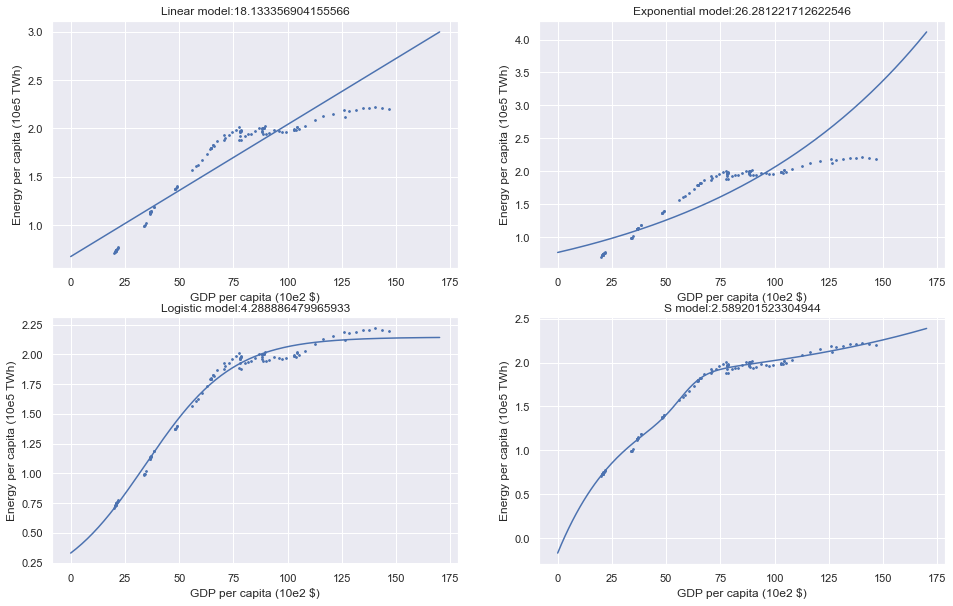

In [34]:
g = final['World GDP in 2011 Int.$ (OWID based on World Bank & Maddison (2017))']/final['Population']/10**2
e  = final['Total (TWh)']/final['Population']*10**5
test_models(g,e, xmin = 0, xmax=170, x_title = 'GDP per capita (10e2 $)', y_title='Energy per capita (10e5 TWh)')

In [35]:
USA = pd.read_csv('../BDD/USA-1850-2008.csv', sep=';')
USA=USA.dropna()
USA.head()

,Year,TotPEC(QuadrillionBTU),GDP(1990GK$),Pop(000)
0,1850.0,2.357,42583.0,23579.7179
1,1860.0,3.162,69346.0,31838.9007
2,1870.0,3.952,98374.0,40240.6295
3,1875.0,4.323,117573.0,45245.0000
4,1880.0,5.001,160656.0,50458.0000


(1935.0, 6.9898443299999995, 9.999725341796875, 0.11908103569897949, -0.0015762132106879408, -0.005673725752231141)


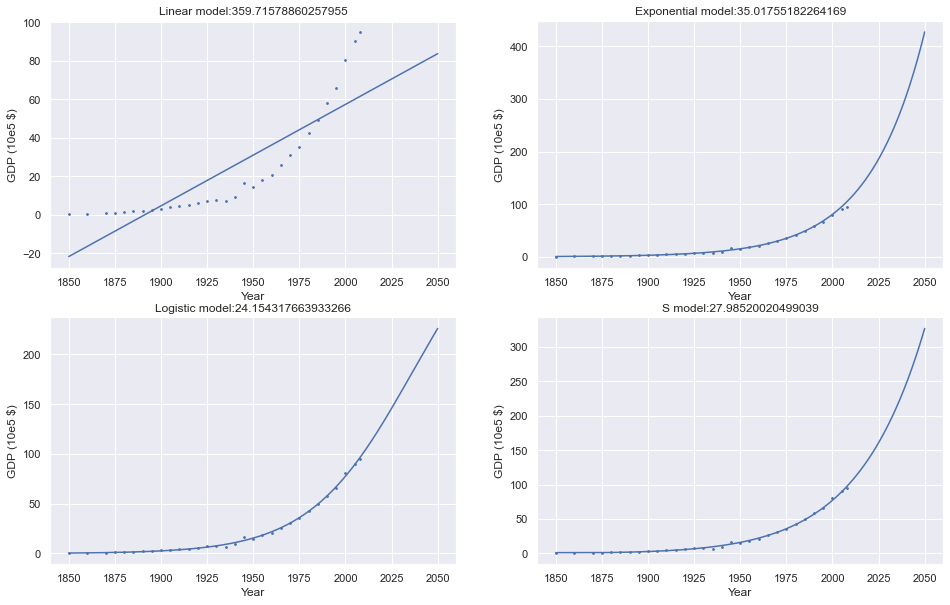

In [36]:
test_models(USA['Year'], USA['GDP(1990GK$)']/10**5, xmin = 1850, xmax=2050, x_title='Year', y_title='GDP (10e5 $)')



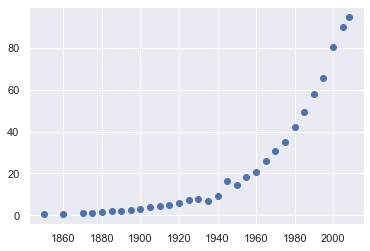

In [37]:
plt.scatter(USA['Year'], USA['GDP(1990GK$)']/10**5)

(1935.0, 5.466837946487928, 9.999725341796875, 0.02504293254903958, 0.013174953245624673, 0.008991859483261174)


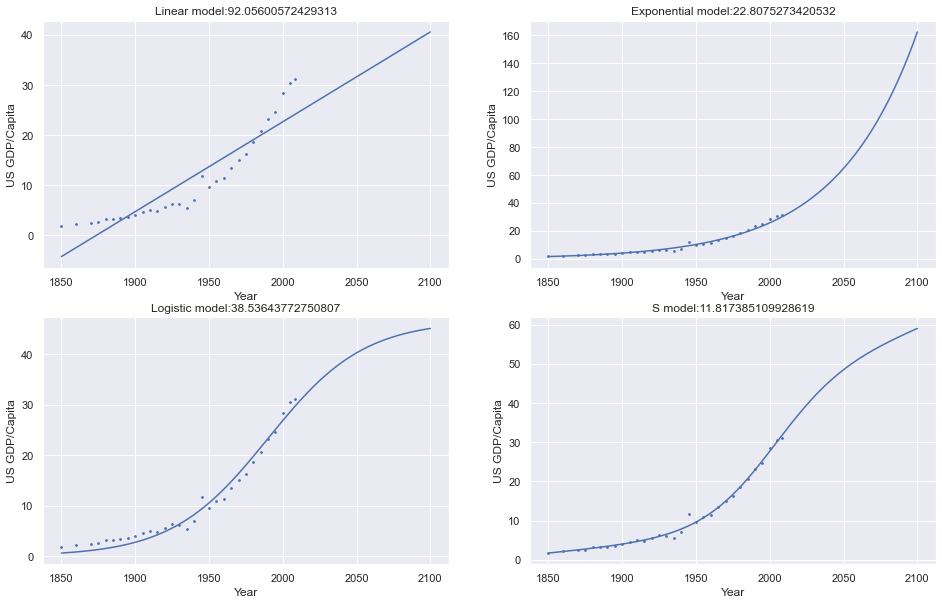

In [38]:
test_models(USA['Year'], USA['GDP(1990GK$)']/USA['Pop(000)'], logbounds=[25,1990], sbounds=[0, 2000], xmin = 1850, xmax = 2100, x_title = 'Year', y_title='US GDP/Capita')

In [44]:
UK = pd.read_csv('../BDD/GDP-per-capita-in-the-uk-since-1270.csv')
UK.columns

Index(['Entity', 'Code', 'Year', 'Real GDP per capita '], dtype='object')

Text(0.5, 1.0, 'GDP per capita, UK')

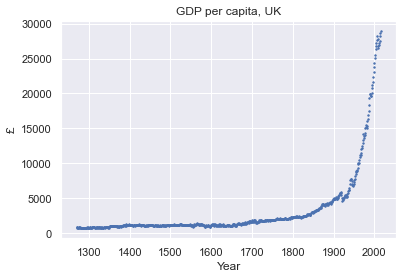

In [48]:
plt.scatter(UK['Year'], UK['Real GDP per capita '], s=2)
plt.xlabel('Year')
plt.ylabel('£')
plt.title('GDP per capita, UK')